# Выбор локации для скважины

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Первым делом рассмотрим данные, проверим их на пропуски, дубликаты и корреляцию. Далее обучим данные моделью линейной регрессии и проверим для каждой среднеквадратическую ошибку. Затем рассчитаем достаточных объем сырья для безубыточной разработки новой скважины и сравним полученный объём со средним запасом в каждом регионе. После чего напишем функцию для расчета прибыли и в итоге посчитаем прибыль и риски для каждого региона и по этим результатам выберем лучший регион.

## 1 Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
BUDGET = 10*10**9
INCOME_ONE = 450000
POINTS = 200

In [3]:
try:
    data1 = pd.read_csv('C:/Users/klimatutti/Downloads/geo_data_0.csv')
    data2 = pd.read_csv('C:/Users/klimatutti/Downloads/geo_data_1.csv')
    data3 = pd.read_csv('C:/Users/klimatutti/Downloads/geo_data_2.csv')
except:
    data1 = pd.read_csv('/datasets/geo_data_0.csv')
    data2 = pd.read_csv('/datasets/geo_data_1.csv')
    data3 = pd.read_csv('/datasets/geo_data_2.csv')

**Рассмотрим первые три строки в любом датасете и изучим общую информацию по каждому.**

In [4]:
data1.head(3)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


**Так как все манипуляции необходимо провести со всеми тремя датасетами, для каждой задачи создадим функцию.**

In [5]:
def info(data):
    print('Размер данных:', data.shape)
    print('Общая информация о данных:', data.info())
    print('Количество пропусков:', data.isna().sum())
    print('Количество дубликатов:', data.duplicated().sum())
    print('Диаграмма корреляции данных', seaborn.heatmap(data.corr(), annot=True, square=True))
    plt.show()
    print('Распределение данных')
    data[["f0","f1","f2"]].hist()
    plt.show()

Размер данных: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Общая информация о данных: None
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество дубликатов: 0
Диаграмма корреляции данных AxesSubplot(0.241667,0.125;0.503333x0.755)


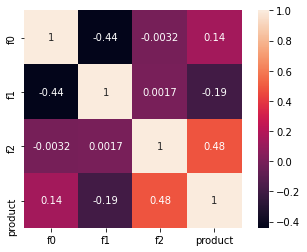

Распределение данных


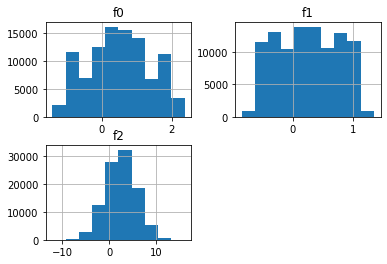

In [6]:
info(data1)

Размер данных: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Общая информация о данных: None
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество дубликатов: 0
Диаграмма корреляции данных AxesSubplot(0.241667,0.125;0.503333x0.755)


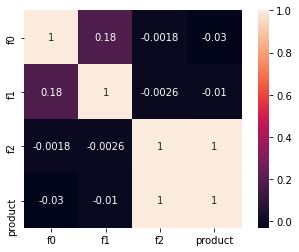

Распределение данных


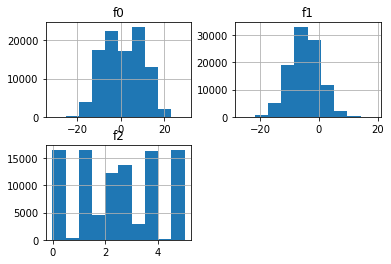

In [7]:
info(data2)

Размер данных: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Общая информация о данных: None
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Количество дубликатов: 0
Диаграмма корреляции данных AxesSubplot(0.241667,0.125;0.503333x0.755)


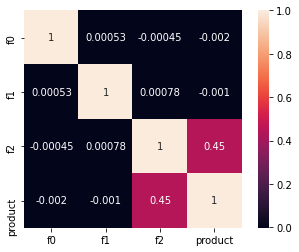

Распределение данных


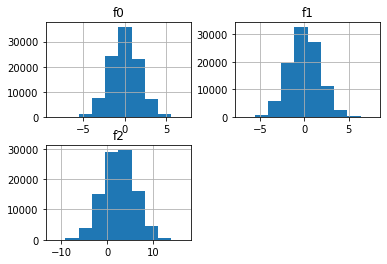

In [8]:
info(data3)

**В каждом из регионов не наблюдается пропусков, дубликатов. При рассмотрении матрицы корреляции можно заметить зависимость между значениями в стобце `f2` и `product` - объем запасов в скважине. Данные в общем ненормально распределены.**

Так как названия столбцов, типы данных записаны правильно, а также нет необходимости избавлятся от пропусков и дубликатов, перейдем к обучению модели.

## Обучение и проверка модели

**Создадим функцию `learn_check_model`, которая на вход принимает датасет. Данная функция определяет признаки и целевой признак, делит данные на обучающую и валидационную выборки, стандартизирует их, обучает по этим данным модель Линейной регрессии и рассчитывает среднеквадратическую ошибку.**

In [11]:
state = np.random.RandomState(12345)
def learn_check_model(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=state)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid))
    rmse = (mean_squared_error(predictions, target_valid)) ** 0.5
    mean = sum(predictions) / len(predictions)
    print('Среднеквадратическая ошибка:', rmse)
    print('Средний запас предсказанного сырья', mean)
    return (predictions, target_valid.reset_index(drop=True), rmse)

Применим функцию к трем датасетам

In [12]:
for i in [data1, data2, data3]:
    learn_check_model(i)
    
    print("\n")

Среднеквадратическая ошибка: 37.5794217150813
Средний запас предсказанного сырья 92.59256778438008


Среднеквадратическая ошибка: 0.8897367737680649
Средний запас предсказанного сырья 68.76995145799782


Среднеквадратическая ошибка: 39.958042459521614
Средний запас предсказанного сырья 95.08752812252328




**Слишком большую среднеквадратическую ошибку имеют регион 1 и регион 3 - почти 40.**

Сохраним данные для дальнейших рассчетов

In [13]:
predictions1, validation1, rmse1 = learn_check_model(data1)
predictions2, validation2, rmse2 = learn_check_model(data2)
predictions3, validation3, rmse3 = learn_check_model(data3)

Среднеквадратическая ошибка: 37.57951548534859
Средний запас предсказанного сырья 92.66386568661606
Среднеквадратическая ошибка: 0.8904163214946189
Средний запас предсказанного сырья 69.22345150014002
Среднеквадратическая ошибка: 40.02938636981283
Средний запас предсказанного сырья 95.04953599535948


## Подготовка к расчёту прибыли

По условию задачи бюджет равен 10 млрд., доход с каждой единицы - 450000. 

Рассчитаем достаточный объем сырья и средний объем запасов в скважине каждого региона.

In [14]:
size = BUDGET / INCOME_ONE / POINTS

print('Для безубыточной разработки новой скважины достаточный объем сырья равен не менее', round(size + 1), 'тысяч баррелей \n')
print('Регион 1:', round(data1['product'].mean()), 'тысяч баррелей')
print('Регион 2:', round(data2['product'].mean()), 'тысяч баррелей')
print('Регион 3:', round(data3['product'].mean()), 'тысяч баррелей')

Для безубыточной разработки новой скважины достаточный объем сырья равен не менее 112 тысяч баррелей 

Регион 1: 93 тысяч баррелей
Регион 2: 69 тысяч баррелей
Регион 3: 95 тысяч баррелей


Одна скважина должна содержать не менее 112 тысяч баррелей, а средний объем в каждом регионе меньше этого значения.

**Создадим функцию для рассчета прибыли**

In [15]:
def income(predictions, target):
    predictions_sort = predictions.sort_values(ascending=False)
    target_sort = target[predictions_sort.index][:POINTS]
    price = target_sort.sum() * INCOME_ONE
    return price - BUDGET

## Расчёт прибыли и рисков 

**Создадим функцию рассчета рисков**

Применим технику Bootstrap с 1000 выборок. Выберем 500 точек и применим функцию рассчета прибыли, в которой мы и отберем 200 точек. Затем посчитаем 95% доверительный интервал, среднюю прибыль каждого региона и значение риска убытков

In [16]:
def income_risk(predictions, target):
    revenue = []
    for _ in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(income(predictions_sample, target_sample)) 
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)
    return ((lower, higher), mean_revenue, risk)

**Применим функции к сохраненным ранее данным.**

In [17]:
for preds, target in zip([predictions1, predictions2, predictions3], [validation1, validation2, validation3]):
    interval, mean_revenue, risk = income_risk(preds, target)
    print('Средняя прибыль:', mean_revenue)
    print('95% доверительный интервал:', interval)
    print('Риск убытков:', risk)
    print('\n')

Средняя прибыль: 429391603
95% доверительный интервал: (-84479358, 937137724)
Риск убытков: 5.300000000000001


Средняя прибыль: 545654352
95% доверительный интервал: (163077982, 976343911)
Риск убытков: 0.2


Средняя прибыль: 432511156
95% доверительный интервал: (-153555072, 967178973)
Риск убытков: 6.4




**Таким образом, регион 1 и регион 3 показали наименьшую прибыль и наибольший риск убытков. Поэтому предлагается регион 2, так как он имеет наибольшую прибыль и наименьший риск убытков.**

## Вывод

В данной работе были проделаны следующие шаги:

- Изучены и проверены на пропуски, дубликаты и зависимости данные;
- Создана функция, которая делит данные на выборки, стандартизирует их и обучает по ним модель. По модели для каждого региона рассчитана среднеквадратическая ошибка;
Регион 1 и Регион 3 показали наибольшее значение среднеквадратической ошибки (почти 40).
- Рассчитан достаточный объём сырья для безубыточной разработки новой скважины и средний объем запасов в каждом регионе. Написана функция рассчета прибыли.
Все регионы показали значение меньше достаточного.
- Создана функция рассчета рисков, которая рассчитывает среднюю прибыль, 95% доверительный интервал и сам риск убытков.

**Финальное применение функций показало, что лучшим вариантом для бурения новой скважины является Регион 2, так как он показал наибольшую прибыль и наименьший риск убытков по сравнению с остальными регионами.**